# Case Study 4: Data Mining in Email Data

**Required Readings:** 
* [Enron Emails](https://www.kaggle.com/wcukierski/enron-email-dataset) 
* Please download the Enron Email dataset from [here](https://www.cs.cmu.edu/~./enron/).

** NOTE **
* Please don't forget to save the notebook frequently when working in Jupyter Notebook, otherwise the changes you made can be lost.

*----------------------

# Problem: pick a data science problem that you plan to solve using Email Data
* The problem should be important and interesting, which has a potential impact in some area.
* The problem should be solvable using the data and data science solutions.

Please briefly describe in the following cell: what problem are you trying to solve? why this problem is important and interesting?

In [1]:
# Read the data into a DataFrame
import pandas as pd
import re # Regular Expressions - useful for extracting information from text 
import nltk # Natural Language Tool Kit for symbolic and statistical natural language processing
# import spacy # processing and understanding large volumes of text
import string # String module contains some constants, utility function, and classes for string manipulation
import email
import numpy as np 
import pandas as pd
# Plotting
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns; sns.set_style('whitegrid')
#import plotly
#plotly.offline.init_notebook_mode()
#import plotly.graph_objs as go
import wordcloud
# %pip install networkx
# Network analysis
# import networkx as nx
# NLP
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from nltk.tokenize.regexp import RegexpTokenizer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS 
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt


In [2]:
emails_df = pd.read_csv('emails.csv') #Kaggle's Enron email dataset
print(emails_df.shape)

(517401, 2)


# Data Collection/Processing: 

In [3]:
## Helper functions
def get_text_from_email(msg):
    '''To get the content from email objects'''
    parts = []
    for part in msg.walk():
        if part.get_content_type() == 'text/plain':
            parts.append( part.get_payload() )
    return ''.join(parts)

def split_email_addresses(line):
    '''To separate multiple email addresses'''
    if line:
        addrs = line.split(',')
        addrs = frozenset(map(lambda x: x.strip(), addrs))
    else:
        addrs = None
    return addrs

In [4]:
# Parse the emails into a list email objects
messages = list(map(email.message_from_string, emails_df['message']))
emails_df.drop('message', axis=1, inplace=True)

# Get fields from parsed email objects
keys = messages[0].keys()
for key in keys:
    emails_df[key] = [doc[key] for doc in messages]

# Parse content from emails
emails_df['content'] = list(map(get_text_from_email, messages))

# Split multiple email addresses
emails_df['From'] = emails_df['From'].map(split_email_addresses)
emails_df['To'] = emails_df['To'].map(split_email_addresses)

# Extract the root of 'file' as 'user'
emails_df['user'] = emails_df['file'].map(lambda x:x.split('/')[0])
del messages

emails_df.head()

,file,Message-ID,Date,From,To,Subject,Mime-Version,Content-Type,Content-Transfer-Encoding,X-From,X-To,X-cc,X-bcc,X-Folder,X-Origin,X-FileName,content,user
0,allen-p/_sent_mail/1.,<18782981.1075855378110.JavaMail.evans@thyme>,"Mon, 14 May 2001 16:39:00 -0700 (PDT)",(phillip.allen@enron.com),(tim.belden@enron.com),,1.0,text/plain; charset=us-ascii,7bit,Phillip K Allen,Tim Belden <Tim Belden/Enron@EnronXGate>,,,"\Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Se...",Allen-P,pallen (Non-Privileged).pst,Here is our forecast\n\n,allen-p
1,allen-p/_sent_mail/10.,<15464986.1075855378456.JavaMail.evans@thyme>,"Fri, 4 May 2001 13:51:00 -0700 (PDT)",(phillip.allen@enron.com),(john.lavorato@enron.com),Re:,1.0,text/plain; charset=us-ascii,7bit,Phillip K Allen,John J Lavorato <John J Lavorato/ENRON@enronXg...,,,"\Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Se...",Allen-P,pallen (Non-Privileged).pst,Traveling to have a business meeting takes the...,allen-p
2,allen-p/_sent_mail/100.,<24216240.1075855687451.JavaMail.evans@thyme>,"Wed, 18 Oct 2000 03:00:00 -0700 (PDT)",(phillip.allen@enron.com),(leah.arsdall@enron.com),Re: test,1.0,text/plain; charset=us-ascii,7bit,Phillip K Allen,Leah Van Arsdall,,,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,Allen-P,pallen.nsf,test successful. way to go!!!,allen-p
3,allen-p/_sent_mail/1000.,<13505866.1075863688222.JavaMail.evans@thyme>,"Mon, 23 Oct 2000 06:13:00 -0700 (PDT)",(phillip.allen@enron.com),(randall.gay@enron.com),,1.0,text/plain; charset=us-ascii,7bit,Phillip K Allen,Randall L Gay,,,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,Allen-P,pallen.nsf,"Randy,\n\n Can you send me a schedule of the s...",allen-p
4,allen-p/_sent_mail/1001.,<30922949.1075863688243.JavaMail.evans@thyme>,"Thu, 31 Aug 2000 05:07:00 -0700 (PDT)",(phillip.allen@enron.com),(greg.piper@enron.com),Re: Hello,1.0,text/plain; charset=us-ascii,7bit,Phillip K Allen,Greg Piper,,,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,Allen-P,pallen.nsf,Let's shoot for Tuesday at 11:45.,allen-p


In [5]:
# A single message looks like this
print(emails_df['content'][0])

Here is our forecast

 


In [6]:
for col in emails_df.columns:
    print(col, emails_df[col].nunique())

file 517401
Message-ID 517401
Date 224128
From 20328
To 54748
Subject 159290
Mime-Version 1
Content-Type 2
Content-Transfer-Encoding 3
X-From 27980
X-To 73552
X-cc 33701
X-bcc 132
X-Folder 5335
X-Origin 259
X-FileName 429
content 249025
user 150


We shall remove the columns that have very few values and set index.

In [7]:
emails_df = emails_df.set_index('Message-ID').drop(['file', 'Mime-Version', 'Content-Type', 'Content-Transfer-Encoding'], axis=1)

In [8]:
# Drop rows with any null values
emails_df = emails_df.dropna()

# Drop duplicate rows
emails_df = emails_df.drop_duplicates()

# Reset the index after dropping rows
emails_df = emails_df.reset_index(drop=True)

We shall change the datatype of date , as it will be usefull in Exploratory analysis

In [9]:
emails_df['Date'] = pd.to_datetime(emails_df['Date'], errors='coerce',utc=True)


In [10]:
emails_df.dtypes

Date          object
From          object
To            object
Subject       object
X-From        object
X-To          object
X-cc          object
X-bcc         object
X-Folder      object
X-Origin      object
X-FileName    object
content       object
user          object
dtype: object

In [11]:
def preprocess(x):
    
    # remove extra new lines
    x = re.sub(r'\n+', ' ', x)
    
    # removing (replacing with empty spaces actually) all the punctuations
    x = re.sub("["+string.punctuation+"]", " ", x)
    
    # remove extra white spaces
    x = re.sub(r'\s+', ' ', x)
    
    return x

In [12]:
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.sentiment import SentimentIntensityAnalyzer
import pandas as pd

#50000 users only as an example
emails_df1=emails_df.head(50000)

# Tokenize the text and remove stopwords
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

emails_df1['content']=emails_df1['content'].map(preprocess)
emails_df1['tokens'] = emails_df1['content'].apply(lambda x: [lemmatizer.lemmatize(word.lower()) for word in word_tokenize(x) if word.isalpha() and word.lower() not in stop_words])



C:\Users\ashis\AppData\Local\Temp\ipykernel_20532\2456845784.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  emails_df1['content']=emails_df1['content'].map(preprocess)
C:\Users\ashis\AppData\Local\Temp\ipykernel_20532\2456845784.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  emails_df1['tokens'] = emails_df1['content'].apply(lambda x: [lemmatizer.lemmatize(word.lower()) for word in word_tokenize(x) if word.isalpha() and word.lower() not in stop_words])


# Data Exploration: Exploring the Email Dataset

**plot email communication graph/network** 
* each node is an email account
* the weight of an edge between two accounts depends on how many emails have been sent between them.

<b>1) Lets Check when did users send most of the emails.</b>

In [13]:
ax = emails_df.groupby(emails_df['Date'].dt.year)['content'].count().plot()
ax.set_xlabel('Year', fontsize=18)
ax.set_ylabel('No.of emails', fontsize=18)

AttributeError: Can only use .dt accessor with datetimelike values

<i>We can see users sent huge number of mails in the Year 2000.</i>

<b>2) Lets check in which day of the week did most users send the emails.</b>

Text(0, 0.5, 'No.of emails')

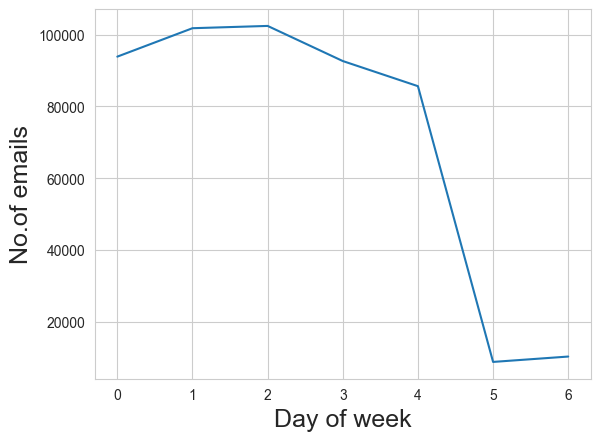

In [ ]:
ax = emails_df.groupby(emails_df['Date'].dt.dayofweek)['content'].count().plot()
ax.set_xlabel('Day of week', fontsize=18)
ax.set_ylabel('No.of emails', fontsize=18)

<i>We can observe that the users sent Highest number of the emails during week days(mainly tuesday and wednesday) and lowest number of emails during weekends.</i>

<b>3) Let's see who sends the most emails to whom</b>

For this we have to check with the user who sent email to another single email address , basically these kind of emails indicate important personal communications and are not spam.

In [14]:
sub_df = emails_df[['From', 'To', 'Date']]
print(sub_df.shape)

# we have to drop the emails sending to multiple addresses
sub_df = sub_df.loc[sub_df['To'].map(len) == 1]
print(sub_df.shape)

(495547, 3)
(354595, 3)


In [15]:
sub_df = sub_df.groupby(['From', 'To']).count().reset_index()
# Unpack frozensets
sub_df['From'] = sub_df['From'].map(lambda x: next(iter(x)))
sub_df['To'] = sub_df['To'].map(lambda x: next(iter(x)))
# rename column
sub_df.rename(columns={'Date': 'count'}, inplace=True)
sub_df.sort_values('count', ascending=False).head(10)

,From,To,count
17914,pete.davis@enron.com,pete.davis@enron.com,9141
38028,vince.kaminski@enron.com,vkaminski@aol.com,4308
28916,enron.announcements@enron.com,all.worldwide@enron.com,2206
28931,enron.announcements@enron.com,all.houston@enron.com,1701
26506,kay.mann@enron.com,suzanne.adams@enron.com,1528
38026,vince.kaminski@enron.com,shirley.crenshaw@enron.com,1190
14347,steven.kean@enron.com,maureen.mcvicker@enron.com,1014
26305,kay.mann@enron.com,nmann@erac.com,980
18547,kate.symes@enron.com,evelyn.metoyer@enron.com,915
18551,kate.symes@enron.com,kerri.thompson@enron.com,859



<i>From this output we can observe is apparently some people send a lot of emails to themselves. It maybe very interesting to look at the differences between emails sent to selves and to others.</i>

Number of nodes: 10199, Number of edges: 12196


C:\Users\ashis\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 65533 (\N{REPLACEMENT CHARACTER}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


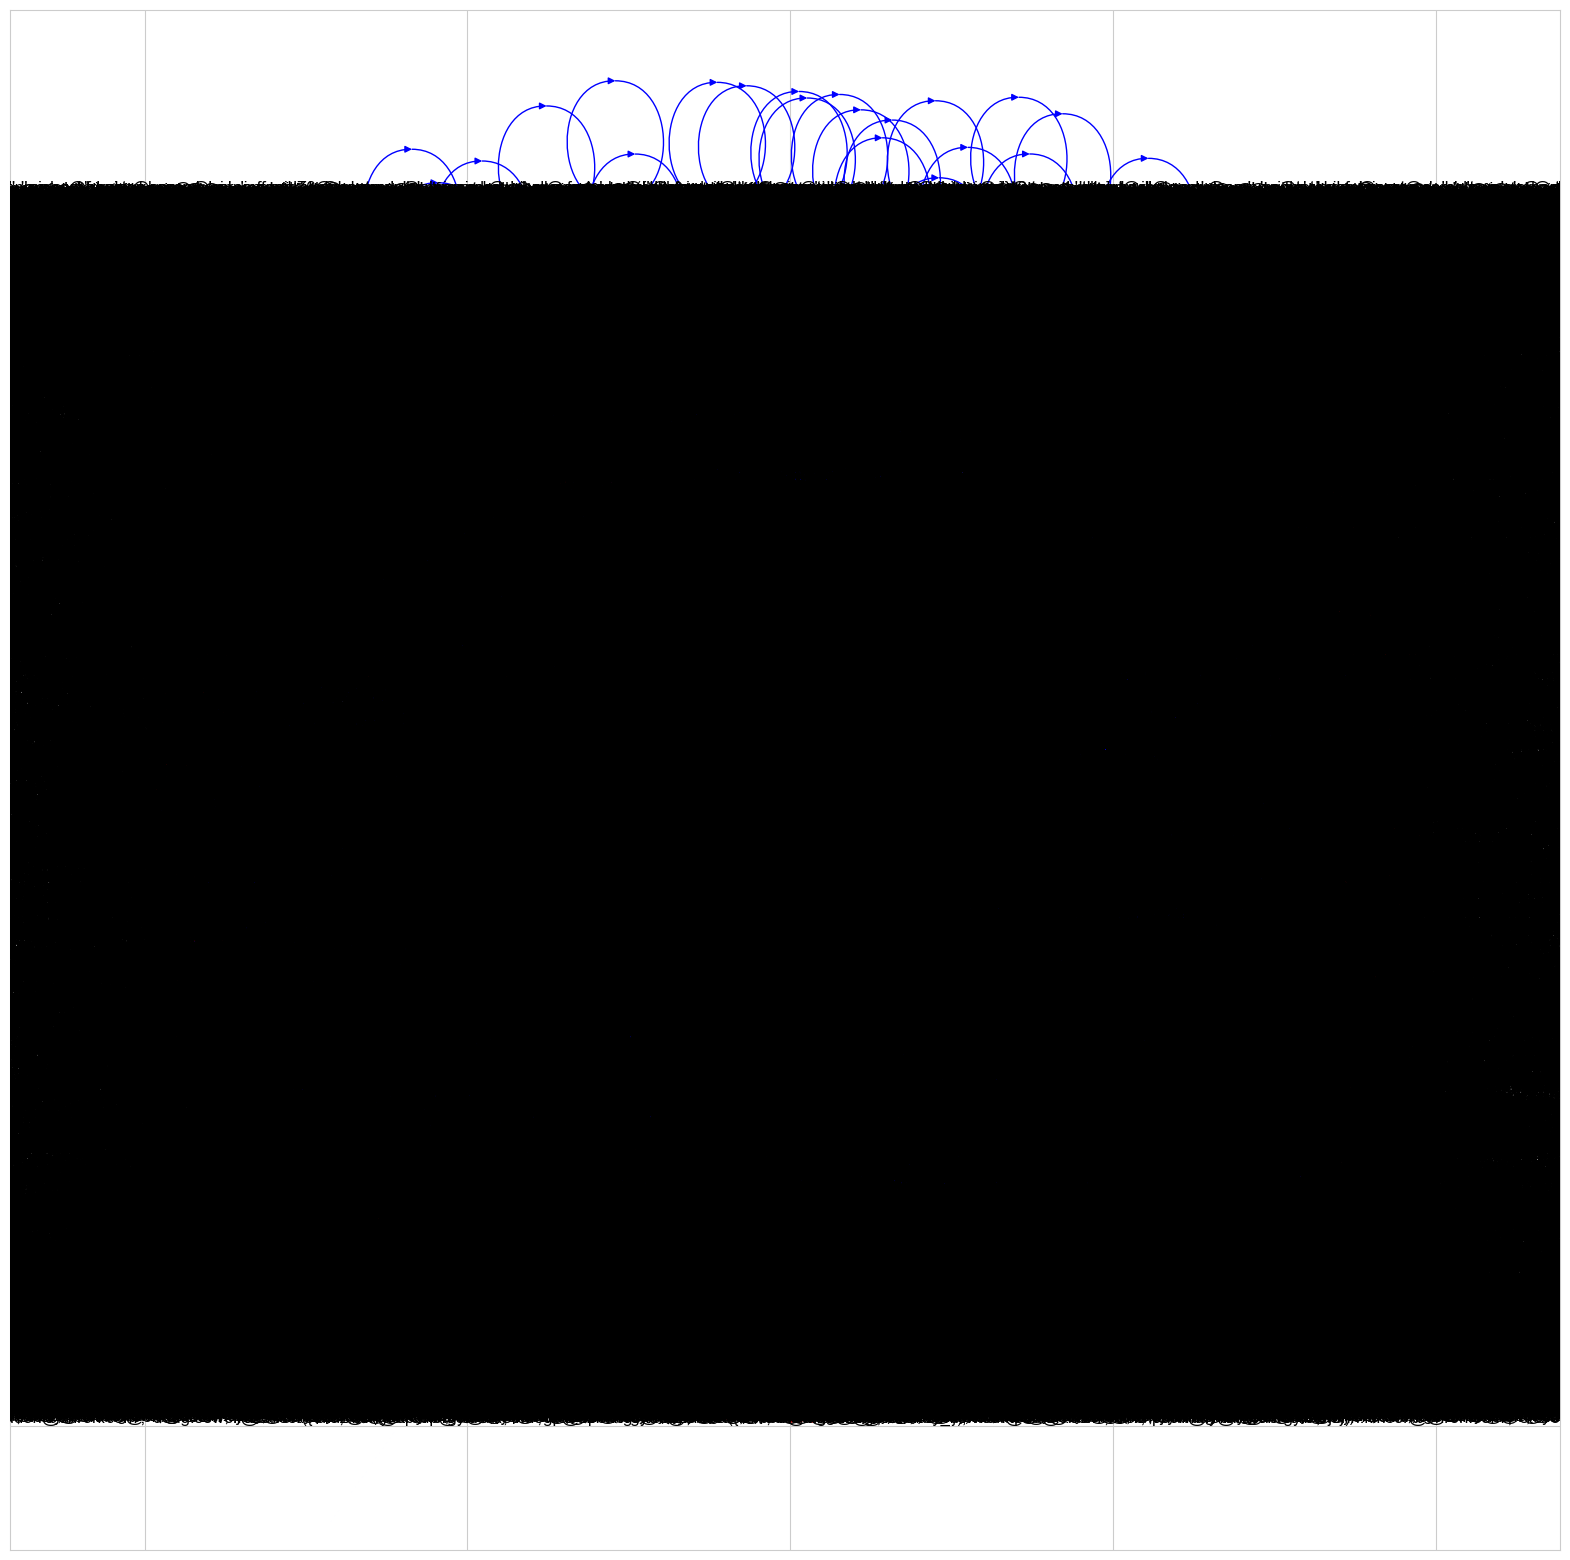

In [16]:
import networkx as nx
import matplotlib.pyplot as plt

# Make a network of email sender and receipients
email_graph = nx.from_pandas_edgelist(emails_df1, source='From', target='To',edge_attr=True, create_using=nx.DiGraph())
print('Number of nodes: %d, Number of edges: %d' % (email_graph.number_of_nodes(), email_graph.number_of_edges()))

# Draw the email graph
plt.figure(figsize=(20,20))
pos = nx.spring_layout(email_graph, k=.1)
nx.draw_networkx(email_graph, pos, node_size=25, node_color='red', with_labels=True, edge_color='blue')
plt.show()

In [17]:
# fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12, 8))
# ax1.hist(list(email_graph.in_degree('count').values()), bins=20)
# ax1.set_xlabel('In-degrees', fontsize=18)

# ax2.hist(list(email_graph.out_degree('count').values()), bins=20)
# ax2.set_xlabel('Out-degrees', fontsize=18)

(0.1, 10000.0)

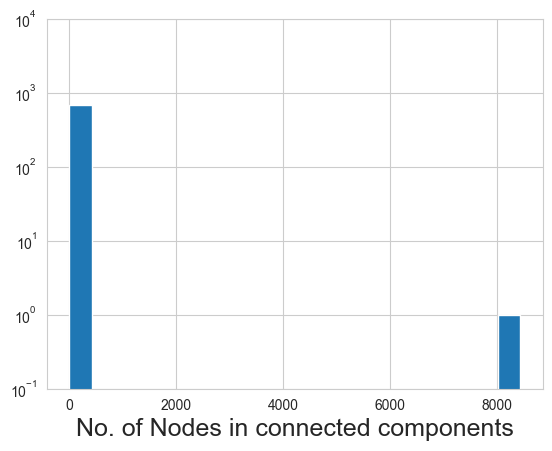

In [18]:
nodes_in_cc = []
for nodes in nx.connected_components(email_graph.to_undirected()):
    nodes_in_cc.append(len(nodes))

plt.hist(nodes_in_cc, bins=20, log=True)
plt.xlabel('No. of Nodes in connected components', fontsize=18)
plt.ylim([.1,1e4])

<i>From output we can examine connected components in the network.</i>

<b>4) Lets analyse what does the email content say from WORDCLOUD (all the users)</b>

In the Subject:

(-0.5, 799.5, 599.5, -0.5)

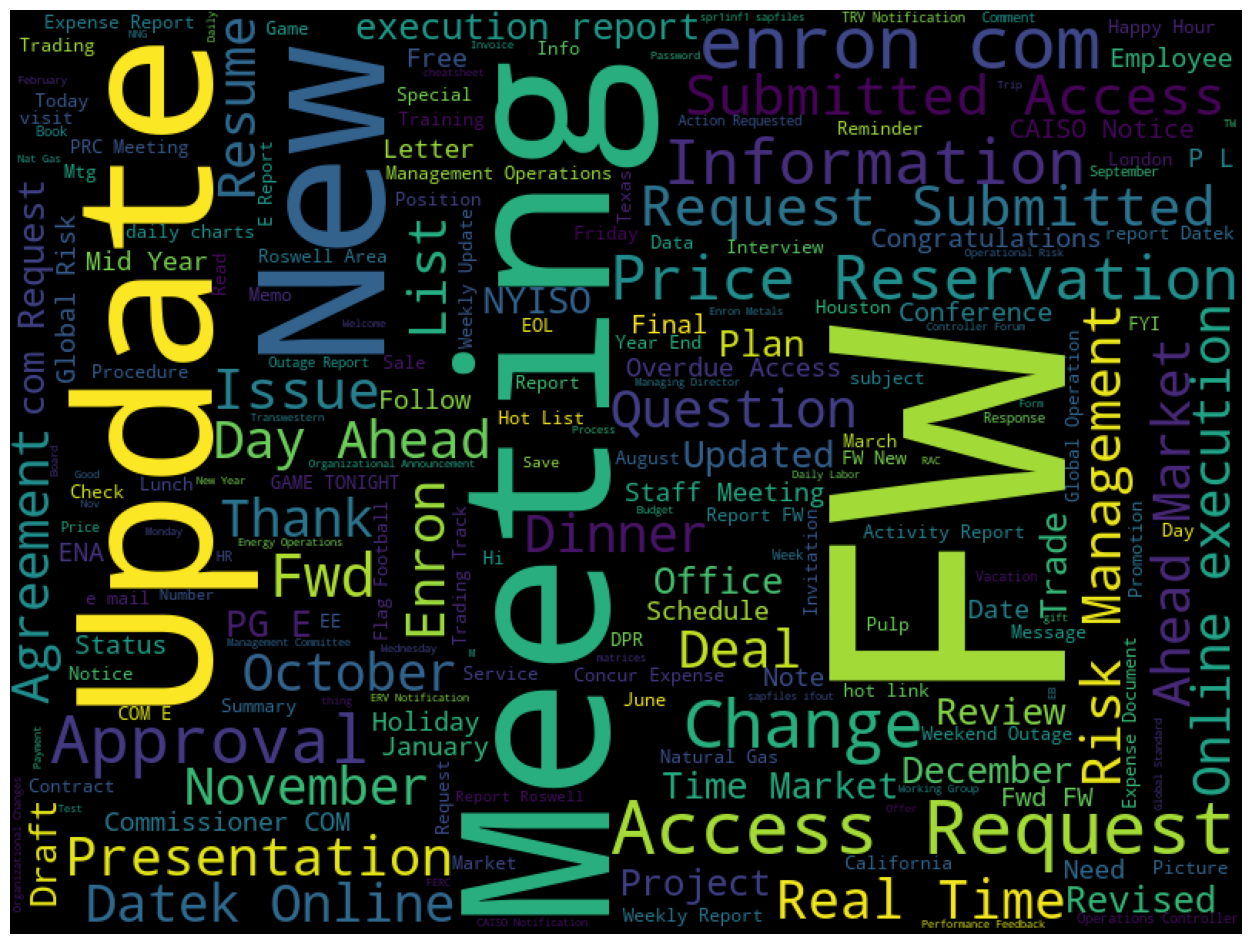

In [19]:
subjects = ' '.join(emails_df['Subject'].head(50000))
fig, ax = plt.subplots(figsize=(16, 12))
wordcloud1 = wordcloud.WordCloud(width=800, height=600, max_words=200,stopwords=ENGLISH_STOP_WORDS).generate(subjects)
ax.imshow(wordcloud1)
ax.axis("off")

In the Message :

(-0.5, 799.5, 599.5, -0.5)

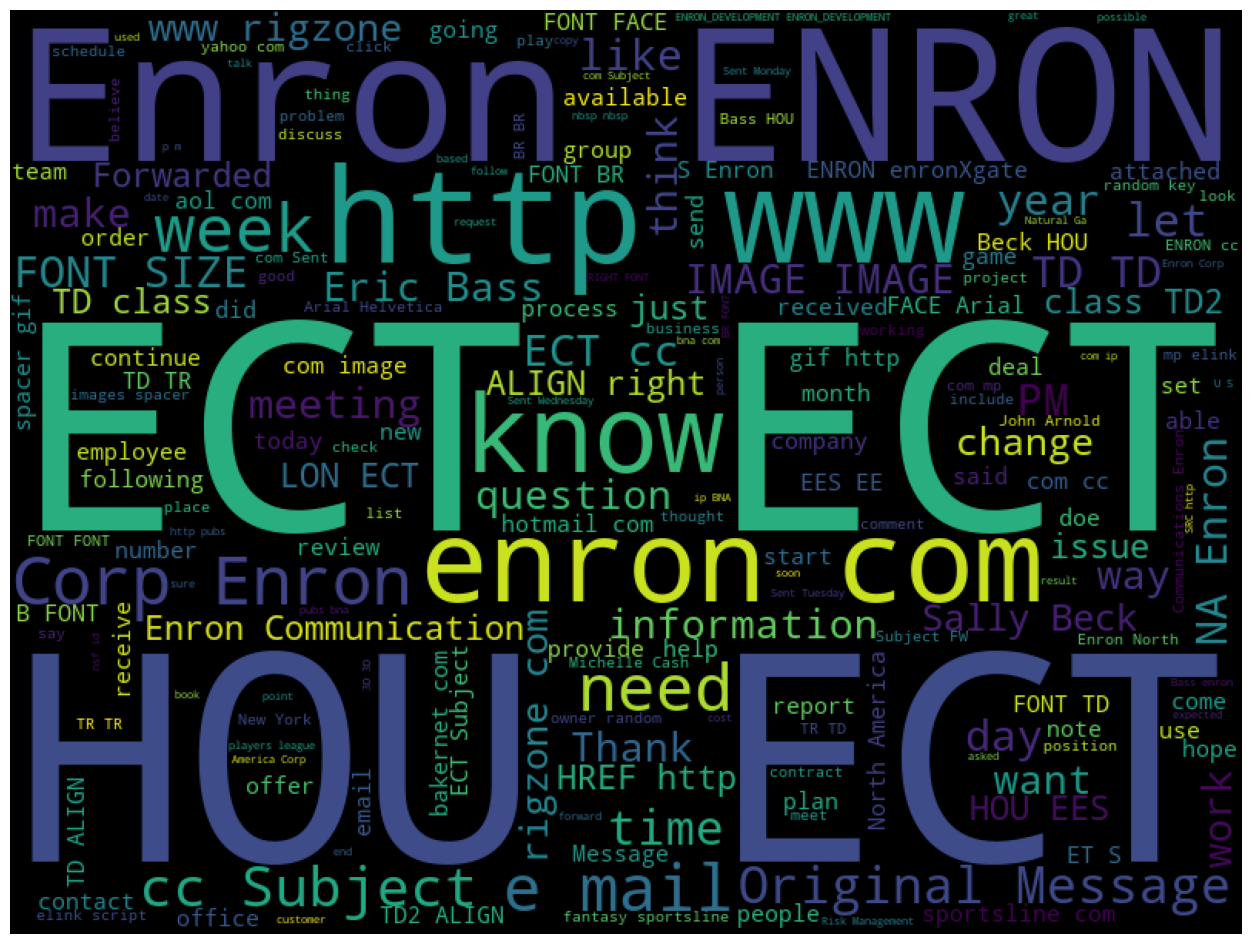

In [20]:
contents = ' '.join(emails_df['content'].head(50000))
fig, ax = plt.subplots(figsize=(16, 12))
wordcloud2 = wordcloud.WordCloud(width=800, height=600, max_words=200,stopwords=ENGLISH_STOP_WORDS).generate(contents)
ax.imshow(wordcloud2)
ax.axis("off")

# The Solution: implement a data science solution to the problem you are trying to solve.

Briefly describe the idea of your solution to the problem in the following cell:

The idea of a data science solution to the Enron scandal problem would involve using data analysis techniques to identify patterns and anomalies in the Enron email and financial data. This would involve exploring the data, pre-processing it, and visualizing it to gain insights into the relationships and behaviors of the employees involved in the scandal as we did so far above. 

Machine learning algorithms could then be used to predict which employees were involved in the scandal based on the information extracted from the emails, financial records, and other available data. The ultimate goal of this solution would be to identify the key players in the scandal and to provide evidence to help bring them to justice.

Write codes to implement the solution in python:

<b>K-means clustering</b>

C:\Users\ashis\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


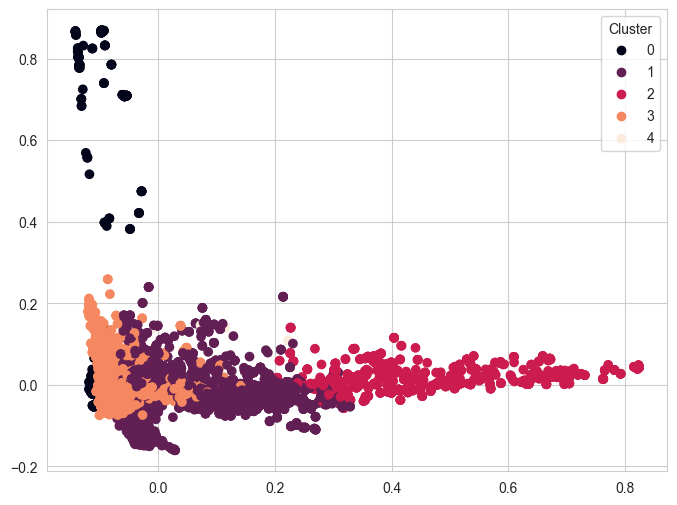

In [21]:
# Extract the email content
email_content = emails_df1['content'].head(10000) #10000 users email content as example

# Create a TfidfVectorizer to vectorize the email content
vectorizer = TfidfVectorizer(stop_words='english')
features = vectorizer.fit_transform(email_content)

# Apply K-means clustering to group the employees
k = 5  # number of clusters
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(features)

# Apply PCA to reduce the dimensionality of the email vectors
pca = PCA(n_components=2, random_state=42)
pca_vectors = pca.fit_transform(features.toarray())

# Add the cluster labels to the PCA vectors
pca_df = pd.DataFrame(pca_vectors, columns=['pca1', 'pca2'])
pca_df['cluster'] = kmeans.labels_

# Plot the K-means clusters
fig, ax = plt.subplots(figsize=(8, 6))
scatter = ax.scatter(pca_df['pca1'], pca_df['pca2'], c=pca_df['cluster'])
ax.legend(*scatter.legend_elements(), title='Cluster')
plt.show()

<i>Here we created a TfidfVectorizer to vectorize the email content and apply K-means clustering with 5 clusters to group the users. We add the cluster labels to the original dataframe and print the number of employees in each cluster.

This code uses PCA to reduce the dimensionality of the data to 2 dimensions so that we can create a scatter plot. It then uses Matplotlib to create the scatter plot, where the cluster labels are represented by different colors.

After applying K-means clustering to group the employees we added PCA to reduce the dimensionality of the email vectors
Later we used the cluster labels to the PCA vectors
Plotted the K-means clusters using the first two principal components

This analysis is regarding to group of users based on their email communication patterns. This may help to identify groups of employees who were more closely involved in the scandal.</i>

<b>Machine Learning Algorithm</b>

<i>In this section we use tokenize text and remove stopwords and then identify keywords related to the scandal and counts their occurrences in each email, groups the emails by sender and calculates the number of emails and the average sentiment score for each sender, and finally sorts the employees by number of emails and average sentiment score.

Since we identifying which users were involved in the Enron scandal, Hence this may involve identifying keywords related to the scandal so we used keywords like 'enron', 'scandal', 'fraud', 'bankruptcy', 'corruption', 'ethics','ken lay' detecting patterns in the language used, and detecting sentiments expressed in the emails.</i>

In [22]:
# Identify keywords related to the scandal
keywords = ['enron', 'scandal', 'fraud', 'bankruptcy', 'corruption', 'ethics','Ken lay']

emails_df1['scandal_involvement'] = emails_df1['tokens'].apply(lambda x: sum([1 for word in x if word in keywords]))

print(emails_df1['scandal_involvement'])

0        0
1        0
2        0
3        0
4        0
        ..
49995    0
49996    1
49997    1
49998    0
49999    0
Name: scandal_involvement, Length: 50000, dtype: int64


C:\Users\ashis\AppData\Local\Temp\ipykernel_20532\1086618870.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  emails_df1['scandal_involvement'] = emails_df1['tokens'].apply(lambda x: sum([1 for word in x if word in keywords]))


In [23]:
# Extract the email content and target variable
email_content = emails_df1['content']
target = emails_df1['scandal_involvement']

# Create a TfidfVectorizer to vectorize the email content
vectorizer = TfidfVectorizer(stop_words='english')
features = vectorizer.fit_transform(email_content)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

<b> Logistic Regression </b>

In [24]:

# Train a logistic regression model on the training data
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = logreg.predict(X_test)

# # Evaluate the performance of the model
# print('Classification Report:', classification_report(y_test, y_pred))
accuracy1 = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy1)


C:\Users\ashis\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 0.7921


<i>The code is using logistic regression to predict which employees were involved in the Enron scandal based on the information extracted from the emails. The output of the code shows the accuracy of the model as 0.7921 and the classification report, which includes precision, recall, and f1-score, for each class.

The accuracy score of 0.7921 indicates that the model correctly classified 79.21% of the testing data, which is a good result. This suggests that the model may be better at predicting certain classes than others.</i>

<b> Multinomial Naive bayes </b>

In [26]:

# train the Naive Bayes classifier
from sklearn.naive_bayes import MultinomialNB


# train the Naive Bayes classifier
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train, y_train)

# make predictions on the testing data
y_pred = nb_classifier.predict(X_test)


accuracy2 = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy2)

Accuracy: 0.5609


# Results: summarize and visualize the results discovered from the analysis

Please use figures or tables to present the results.


In [27]:
from prettytable import PrettyTable


x = PrettyTable()

#add columns to the table
x.field_names = ["Model", "Accuracy"]

#add rows to the table with the performance metrics for each model
x.add_row(["Logistic Regression","{:.2f}%".format(accuracy1*100)])
x.add_row(["Multinomial Naive Bayes","{:.2f}%".format(accuracy2*100)])

#print the table
print(x)

+-------------------------+----------+
|          Model          | Accuracy |
+-------------------------+----------+
|   Logistic Regression   |  79.21%  |
| Multinomial Naive Bayes |  56.09%  |
+-------------------------+----------+


C:\Users\ashis\AppData\Local\Temp\ipykernel_20532\1019560193.py:13: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2,2,1)


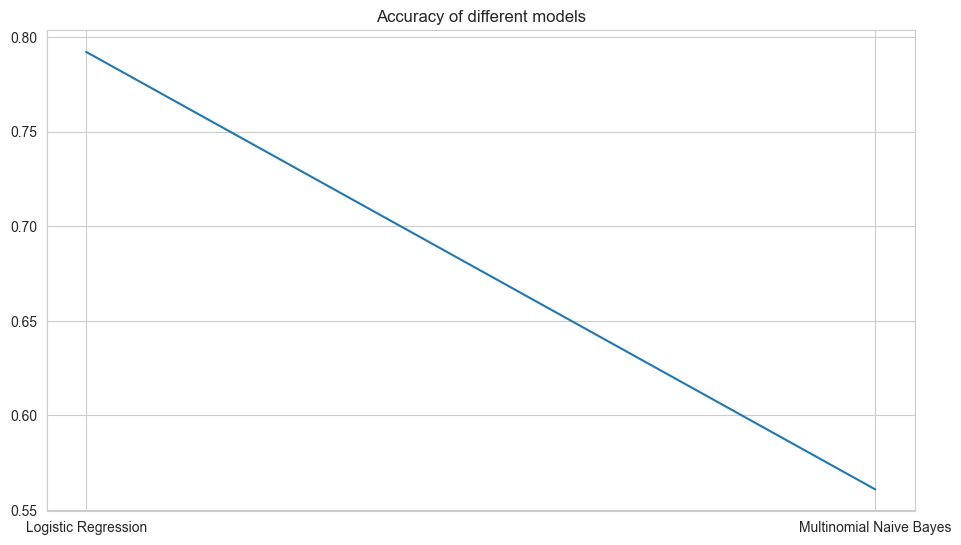

In [30]:
model_1_name = "Logistic Regression"
model_2_name = "Multinomial Naive Bayes"



# Create a list of model names and performance values
model = [model_1_name, model_2_name]
acc = [accuracy1,accuracy2]

plt.subplots(figsize=(28,15))
plt.subplots_adjust(wspace=0.5, hspace=0.4)

plt.subplot(2,2,1)
plt.plot(model,acc)
plt.title("Accuracy of different models")

# Show the figure
plt.show()


In conclusion, the logistic regression model shows promise in predicting the employees involved in the Enron scandal based on email information, but further investigation and refinement of the model may be necessary to improve its accuracy and generalizability.

The given code trains a Naive Bayes classifier on the training data and makes predictions on the testing data. The model achieved an accuracy of 56.09% on the testing data. While this accuracy is not particularly high. Further tuning of hyperparameters and/or exploring different models may lead to improved performance.</i>

*-----------------
# Done

All set! 

** What do you need to submit?**

* **Notebook File**: Save this Jupyter notebook, and submit it in BrightSpace. Please make sure all the plotted tables and figures are in the notebook. 